In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import shap

In [2]:
"Read in clean-data"
df = pd.read_csv("clean_df.csv")

In [3]:
"Configure features and target"
# Define target column
target_col = "Price"

# Split features/target
x = df.drop(columns=[target_col])
y = df[target_col].astype(float)

In [4]:
"Split data into training and test sets"
# Split: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

In [5]:
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

for col in categorical_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])

In [6]:
# Initialize XGBoost model with base parameters
base_model = xgb.XGBRegressor(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror'
)

In [7]:
X_train.dtypes

Manufacturer             int32
Model                    int32
Engine size            float64
Fuel type                int32
Year of manufacture      int64
Mileage                  int64
Car Age                  int64
dtype: object

In [8]:
"Tune hyperparameters with GridSearchCV"
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.15],
    'max_depth': [6, 8],
    'subsample': [0.8, 0.9]
}

grid_search = GridSearchCV(
    base_model, 
    param_grid, 
    cv=3, 
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    device=None, early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.1, max...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=6, max_leaves=None,
                                    min_child_weight=1, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.15], 'max_depth': [6, 8],
                         'n_estimators': [100, 200], 'subsample': [0.8, 0.9]},
             scoring='neg_mean_squared_error', verbose=1)

In [9]:
"Best model"
model = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {-grid_search.best_score_:.2f}")

Best parameters: {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200, 'subsample': 0.8}
Best cross-validation score: 207166.39


In [10]:
"Make predictions"
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [11]:
"Metrics"

# Calculate metrics
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Training Set Metrics:")
print(f"  MAE: {train_mae:.4f}")
print(f"  RMSE: {train_rmse:.4f}")
print(f"  MSE: {train_mse:.4f}")
print(f"  R²: {train_r2:.4f}")

print("\nTest Set Metrics:")
print(f"  MAE: {test_mae:.4f}")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  MSE: {test_mse:.4f}")
print(f"  R²: {test_r2:.4f}")

# Calculate percentage errors
train_mape = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

print(f"\nMean Absolute Percentage Error:")
print(f"  Training: {train_mape:.4f}%")
print(f"  Test: {test_mape:.4f}%")


Training Set Metrics:
  MAE: 139.8198
  RMSE: 211.1965
  MSE: 44603.9700
  R²: 0.9998

Test Set Metrics:
  MAE: 189.7065
  RMSE: 346.5573
  MSE: 120101.9435
  R²: 0.9996

Mean Absolute Percentage Error:
  Training: 2.0325%
  Test: 2.3964%


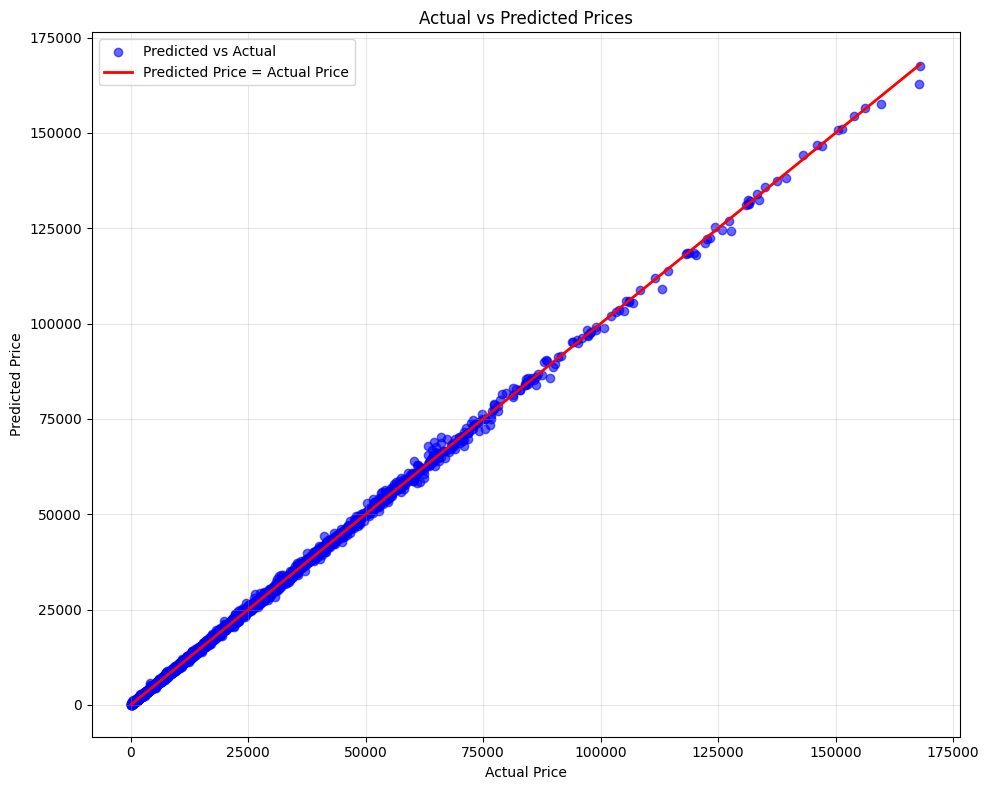

In [ ]:
# Plot: Actual vs Predicted Scatter Plot
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_test_pred, alpha=0.6, color='blue', label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r-', lw=2, label='Predicted Price = Actual Price')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices')
plt.grid(True, alpha=0.3)
plt.legend(loc='best', frameon=True)
plt.tight_layout()
plt.show()


In [14]:
"Save model"

# Metadata
model_info = {
    'best_params': grid_search.best_params_,
    'best_score': grid_search.best_score_,
    'feature_names': list(X_train.columns),
    'model_type': 'xgboost'
}

joblib.dump({
    'model': model,
    'label_encoders': {col: le for col, le in zip(categorical_cols, [LabelEncoder().fit(X_train[col]) for col in categorical_cols])} if 'categorical_cols' in locals() else {},
    'feature_names': list(X_train.columns),
    'metadata': model_info
}, 'XGB_model.joblib')


# Load 
loaded = joblib.load('XGB_model.joblib')
model = loaded['model']
label_encoders = loaded['label_encoders']
feature_names = loaded['feature_names'] 

In [15]:
"Function to predict on new data"
def predict_price_xgb(new_data):
    X_new = new_data.copy()
    for col, le in label_encoders.items():
        if col in X_new:
            X_new[col] = le.transform(X_new[col].astype(str))
    X_new = X_new[feature_names]
    prediction = model.predict(X_new)
    return prediction[0]

In [16]:
"Example"
new_car_data = pd.DataFrame({
    'Make': ['Toyota'],
    'Model': ['Camry'],
    'Year': [2023],
    'Mileage': [25000],
    'Engine_Size': [2.5],
})

In [17]:
"Test prediction on samples from test set"
sample_new_data = X_test.iloc[:10].copy()
actual_prices = y_test.iloc[:10].copy()

for i in range(len(sample_new_data)):
    row_df = sample_new_data.iloc[[i]]          
    predicted_price = predict_price_xgb(row_df)
    actual_price    = float(actual_prices.iloc[i])

    print(f"Sample {i+1}:")
    print(f"  Predicted Price: £{predicted_price:,.4f}")
    print(f"  Actual Price:    £{actual_price:,.4f}")
    print(f"  Error:           £{abs(predicted_price - actual_price):,.4f}\n")

Sample 1:
  Predicted Price: £28,158.8613
  Actual Price:    £28,636.0000
  Error:           £477.1387

Sample 2:
  Predicted Price: £59,358.8438
  Actual Price:    £59,783.0000
  Error:           £424.1562

Sample 3:
  Predicted Price: £14,788.9492
  Actual Price:    £14,865.0000
  Error:           £76.0508

Sample 4:
  Predicted Price: £2,511.8018
  Actual Price:    £2,219.0000
  Error:           £292.8018

Sample 5:
  Predicted Price: £997.2564
  Actual Price:    £1,001.0000
  Error:           £3.7436

Sample 6:
  Predicted Price: £1,375.9983
  Actual Price:    £1,415.0000
  Error:           £39.0017

Sample 7:
  Predicted Price: £105,884.6953
  Actual Price:    £106,073.0000
  Error:           £188.3047

Sample 8:
  Predicted Price: £1,920.7651
  Actual Price:    £2,023.0000
  Error:           £102.2349

Sample 9:
  Predicted Price: £15,262.0391
  Actual Price:    £15,492.0000
  Error:           £229.9609

Sample 10:
  Predicted Price: £3,422.8081
  Actual Price:    £3,465.0000
  E

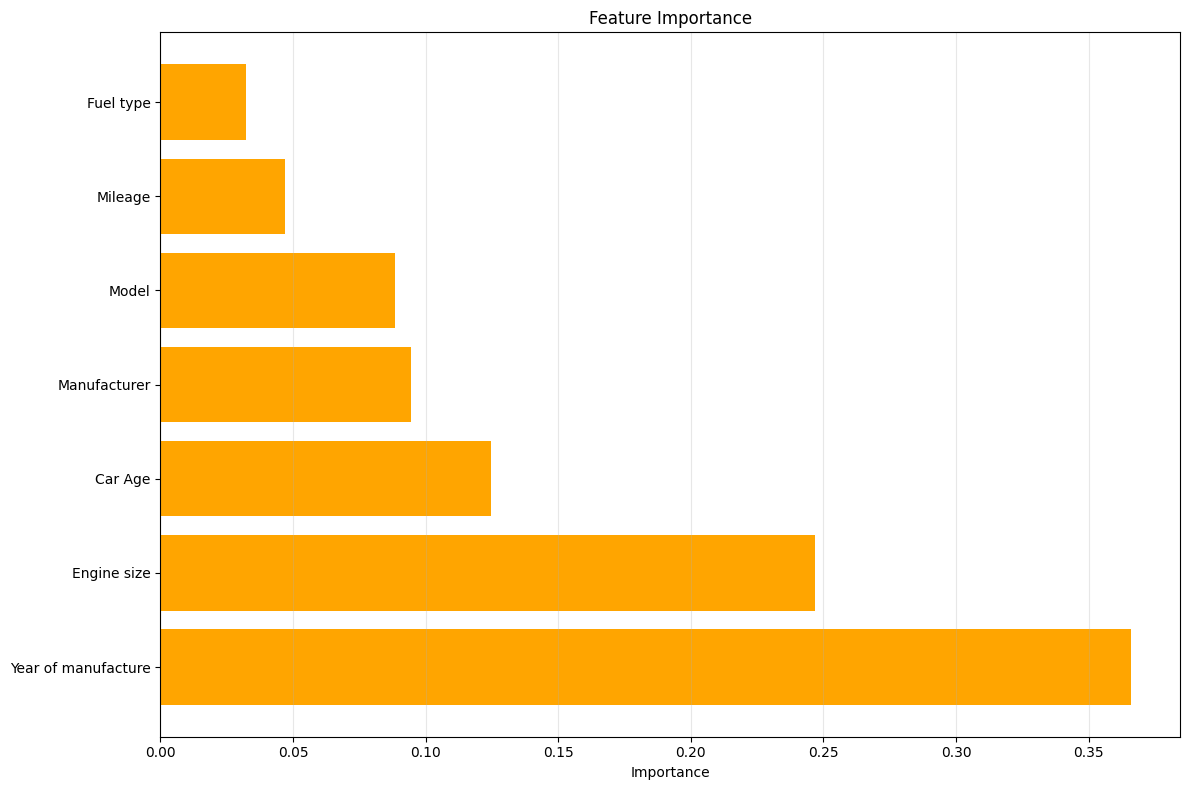

In [18]:
"Feature importance"
feature_importance = pd.DataFrame({
    'feature': x.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=True)

# Plot: Feature Importance
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(10)
plt.barh(range(len(top_features)), top_features['importance'], color='orange')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis() 
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

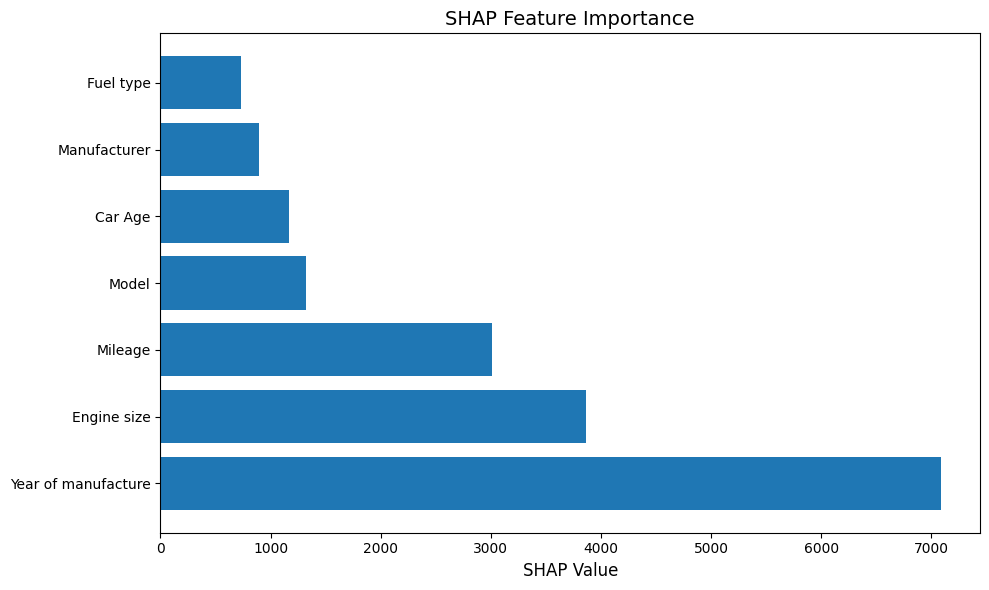

In [25]:
"SHAP analysis"

# Initialize SHAP explainer
explainer = shap.Explainer(model)

# Calculate SHAP values for test set
sample_size = min(500, len(X_test)) 
X_test_sample = X_test.head(sample_size)
y_test_sample = y_test.head(sample_size)

shap_values = explainer(X_test_sample)

# Group SHAP values by parent feature
def get_parent_feature(feature_name):
    if feature_name.startswith('Manufacturer_'):
        return 'Manufacturer'
    elif feature_name.startswith('Model_'):
        return 'Model'
    elif feature_name.startswith('Fuel type_'):
        return 'Fuel type'
    else:
        return feature_name

# Calculate mean absolute SHAP values
feature_importance = np.mean(np.abs(shap_values.values), axis=0)

# Group and average by parent feature
grouped_shap = {}
feature_counts = {}

for i, feature_name in enumerate(X_test_sample.columns):
    parent_feature = get_parent_feature(feature_name)
    if parent_feature in grouped_shap:
        grouped_shap[parent_feature] += feature_importance[i]
        feature_counts[parent_feature] += 1
    else:
        grouped_shap[parent_feature] = feature_importance[i]
        feature_counts[parent_feature] = 1

# Calculate mean
for feature in grouped_shap:
    grouped_shap[feature] /= feature_counts[feature]

# Create DataFrame and sort
shap_df = pd.DataFrame({
    'Feature': list(grouped_shap.keys()),
    'SHAP_Importance': list(grouped_shap.values())
}).sort_values('SHAP_Importance', ascending=False)

# Create plot matching neural network style
plt.figure(figsize=(10, 6))
plt.barh(shap_df['Feature'], shap_df['SHAP_Importance'], color='#1f77b4')

plt.xlabel('SHAP Value', fontsize=12)
plt.title('SHAP Feature Importance', fontsize=14)

# Remove grid
plt.grid(False)

# Keep all spines visible
plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
plt.gca().spines['left'].set_visible(True)

plt.tight_layout()
plt.show()